## Data Bootcamp Final Project 
### Project Members: Susan Chen (sc6354), Brandon (be678) , Chloe (Yue Chen, yc2938) 

In [20]:
#import packages
import pandas as pd 
import os 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
from IPython.display import display, Markdown
pd.options.mode.chained_assignment = None


## This notebook is divided into three sections: 
## 1. Exploratory Analysis of both the Apps and Reviews Dataset 
## 2. another section 
## 3. Topic Modeling of Reviews

In [21]:
#display(Markdown('# `Import Datasets`'))
os.chdir("../data_bootcamp_final") #this line depends on your local directory, set it to the folder you save the notebook in 

# apps = pd.read_csv('googleplaystore.csv')
# reviews = pd.read_csv('googleplaystore_user_reviews.csv')

#Brandon Directory
apps = pd.read_csv('/Users/brandeap/Documents/GitHub/data_bootcamp_final/data/googleplaystore.csv')
reviews = pd.read_csv('/Users/brandeap/Documents/GitHub/data_bootcamp_final/data/googleplaystore_user_reviews.csv')

## `Data Dictionary` 
This dataset is available on [Kaggle.com](https://www.kaggle.com/lava18/google-play-store-apps).

Apps: 
- App - Application Name 
- Category - Category the App belongs to 
- Rating - Overall user rating of the App
- Reviews - Number of user reviews for app 
- Size - Size of App 
- Installs - number of downloads 
- Type - Is the App paid or Free?
- Price - Price if not free 
- Content Rating - Age group the app is targeted at
- Genres - An app can belong to multiple genres (apart from its main category)

Reviews: 
- App - Name of App
- Translated_Review - user review
- Sentiment - Positive/Negative/Neutral 
- Sentiment_Polarity - Sentiment polarity score 
- Sentiment_Subjectivity - Sentiment subjectivity score 

## `Changing Data types`

In [22]:
print(apps.dtypes)

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


In [23]:
# this row appears to be problematic, some the values are shifted one place up
apps.iloc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                                 19
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [24]:
apps.at[10472, ['Last Updated', 'Genres', 'Content Rating', 'Price', 'Type', 'Installs', 'Size', 'Reviews', 'Rating', 'Category']] = ['February 11, 2018', np.nan, 'Everyone', 0, 'Free', '1,000+', '3.0M', 19, 1.9, np.nan]
apps.iloc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              NaN
Rating                                                1.9
Reviews                                                19
Size                                                 3.0M
Installs                                           1,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Genres                                                NaN
Last Updated                            February 11, 2018
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [25]:
# change Rating, Reviews, Size, Installs, and Price to floats
apps['Rating'] = pd.to_numeric(apps['Rating'])
apps['Reviews'] = pd.to_numeric(apps["Reviews"])
# one megabyte is equal to 1000 kilobytes; convert kilobyte to megabyte by dividing by 1000 and remove the M
for i in range(len(apps)):
    if 'k' in apps.Size[i]:
        apps.Size[i] = pd.to_numeric(apps.Size[i][:-1])/1000
    elif 'M' in apps.Size[i]:
        apps.Size[i] = apps.Size[i][:-1]
    elif "Varies with device" in apps.Size[i]: 
        apps.Size[i] = np.nan
apps['Size'] = pd.to_numeric(apps['Size'])
apps['Installs'] = pd.to_numeric(apps['Installs'].str[:-1].str.replace(',', ''))
apps['Price'] = pd.to_numeric(apps['Price'].str.replace('$', ''))
apps['Last Updated'] = pd.to_datetime(apps['Last Updated'])

In [26]:
apps.describe()

,Rating,Reviews,Size,Installs,Price
count,9367.000000,1.084100e+04,9146.000000,1.084000e+04,10840.000000
mean,4.191513,4.441119e+05,21.514505,1.546434e+07,1.027368
std,0.515735,2.927629e+06,22.588343,8.502936e+07,15.949703
min,1.000000,0.000000e+00,0.008500,0.000000e+00,0.000000
25%,4.000000,3.800000e+01,4.900000,1.000000e+03,0.000000
50%,4.300000,2.094000e+03,13.000000,1.000000e+05,0.000000
75%,4.500000,5.476800e+04,30.000000,5.000000e+06,0.000000
max,5.000000,7.815831e+07,100.000000,1.000000e+09,400.000000


# `Section 1`

## 1.1 let's use this format for numbering subsections

## 1.2 another subsection

# `Section 2`

# some ideas: what is the most popular paid app?, what app has the most negative reviews and what is its rating and plotting number of ratings against proportion of negative review. What is the most popular app by category and target audience?



# `Section 3: Topic Modeling of Reviews `

In [27]:
reviews

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
...,...,...,...,...,...
64290,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64291,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64292,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64293,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN


In [28]:
# remove rows with NaN
reviews = reviews.dropna()
# check how many apps are in the reviews dataset and subset the one with the most reviews to model
reviews.App.value_counts()

Bowmasters                                            312
Helix Jump                                            273
Angry Birds Classic                                   273
Calorie Counter - MyFitnessPal                        254
Duolingo: Learn Languages Free                        240
                                                     ... 
DashClock Widget                                        1
Discover Mobile                                         1
Drawing for Kids Learning Games for Toddlers age 3      1
All-in-One Mahjong 3 FREE                               1
Caller ID +                                             1
Name: App, Length: 865, dtype: int64

In [29]:
# create a dataframe of the App with the most reviews
bm_df = reviews[reviews['App']=="Bowmasters"]
bm_df

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
16887,Bowmasters,Really like game far. Great gameplay lots fun....,Positive,0.116667,0.542593
16888,Bowmasters,Easy play round two minutes. Characters hilari...,Positive,0.165152,0.560606
16889,Bowmasters,I would give game stars many problems. Lag eve...,Negative,-0.357143,0.571429
16890,Bowmasters,"It's ok, making us pay per week ads absurd edi...",Positive,0.016667,0.441667
16891,Bowmasters,"Should vary videos required watch, least give ...",Positive,0.042857,0.394286
...,...,...,...,...,...
17202,Bowmasters,It really good lots fun addictive I would say ...,Positive,0.071429,0.514286
17203,Bowmasters,Its pretty addicting please fix guy CD broken....,Positive,0.016667,0.533333
17204,Bowmasters,This magical game children play. If like wonde...,Positive,0.175000,0.700000
17205,Bowmasters,Little reason keep playing. Only way earn coin...,Positive,0.022500,0.520000


## 3.1 Starting off easy: How many negative reviews do Bowmasters have?

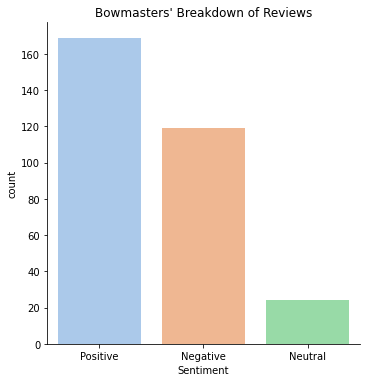

In [30]:
display(Markdown('## 3.1 Starting off easy: How many negative reviews do Bowmasters have?'))
sns.catplot(x="Sentiment", kind="count", data=bm_df, palette="pastel").set(title="Bowmasters' Breakdown of Reviews")


### The barplot clearly illustrates that approximately half of Bowmaster's revies are either negative or neutral. This is not a good situation to be in as the app clearly has room to improve. 

## 3.2 We know that Bowmasters has many negative reviews but what are users complaining about?'

In [31]:
neg_reviews = bm_df[bm_df["Sentiment"]=="Negative"]
neg_reviews

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
16889,Bowmasters,I would give game stars many problems. Lag eve...,Negative,-0.357143,0.571429
16895,Bowmasters,The game entertaining game randomly send ad pa...,Negative,-0.260000,0.500000
16900,Bowmasters,This game great even 5 year old brother plays ...,Negative,-0.036533,0.455952
16901,Bowmasters,I rate 4 stars ads chests really annoying I'm ...,Negative,-0.182727,0.570909
16905,Bowmasters,I got I really like it! Too much blood too! An...,Negative,-0.020833,0.466667
...,...,...,...,...,...
17196,Bowmasters,Loved game. Hated would freeze everytime I ref...,Negative,-0.108333,0.575000
17198,Bowmasters,Ad based chest drops horrendous game whole mem...,Negative,-0.100000,0.400000
17199,Bowmasters,I really like game fun play crashes often. Als...,Negative,-0.013333,0.246667
17201,Bowmasters,Great game pass time with. Almost reminds angr...,Negative,-0.033333,0.716667


In [33]:
## hi,brandon and chloe, if you want be able to run this part, you might need to install the following modules 
pip install nltk 
pip install gensim

# and then run this in the terminal or command prompt
# python3 -m spacy download en

# I don't know what modules you guys have install on your computer but if you get the ModuleNotFoundError, just run pip install [module] directly in the notebook
# -Susan

SyntaxError: invalid syntax (<ipython-input-33-9a20898125ec>, line 2)

In [34]:
import nltk; nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brandeap/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [38]:
import re
from pprint import pprint 
from nltk.corpus import stopwords
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [39]:
# NLTK stop words
stop_words = stopwords.words('english')
neg = neg_reviews['Translated_Review'].values.tolist()

In [40]:
print(neg[10:15])
# the reviews look pretty cleans, so we can move straight into tokenizaiton 

['Loved game. Hated would freeze everytime I refused targeted ads. Disappointed. Was really enjoying much', "Ad based chest drops horrendous game whole member ship scheme y'all adopted pitiful happened buying 2 bucks", "I really like game fun play crashes often. Also I get passed second opponent tournament mode screen goes black I can't continue.", 'Great game pass time with. Almost reminds angry birds', 'Its fun short round pvp ridiculously gruesome kill scenes done cartoon fashion. Nothing negative say; I look forward unlocking characters.']


In [41]:
# function tokenize words 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

review_words = list(sent_to_words(neg))
print(review_words[:1])

[['would', 'give', 'game', 'stars', 'many', 'problems', 'lag', 'everywhere', 'game', 'ads', 'make', 'worse', 'mind', 'watching', 'game', 'awful', 'it', 'makes', 'gameplay', 'unplayable', 'unenjoyable', 'please', 'fix', 'problems']]


In [16]:
# these are functions for removing stopwords, creating bigrams and trigrams, performing lemmatization 
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

bigram = gensim.models.Phrases(review_words , min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[review_words ], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
# Remove Stop Words
rev_words_nostops = remove_stopwords(review_words)
# Form Bigrams
rev_words_bigrams = make_bigrams(rev_words_nostops)
# Initialize spacy 'en' model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Perform lemmatization keeping only noun, adj, vb, adv
rev_lemmatized = lemmatization(rev_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print the first review to view results
print(rev_lemmatized[:1])

[['give', 'game', 'star', 'many', 'problem', 'lag', 'everywhere', 'game', 'ad', 'make', 'bad', 'mind', 'watch', 'game', 'awful', 'make', 'gameplay', 'unplayable', 'unenjoyable', 'fix', 'problem']]


In [18]:
# create corpus 
words = corpora.Dictionary(rev_lemmatized)
# create term document frequency 
corpus = [words.doc2bow(rev) for rev in rev_lemmatized]
print(corpus[:1])
words[0]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1)]]


'ad'

In [19]:
# build the LDA topic model assuming that the number of topics is 10
topics = gensim.models.ldamodel.LdaModel(corpus = corpus,id2word= words,num_topics=10,random_state=100,
                                         update_every=1,chunksize=30,alpha='auto',per_word_topics=True)

In [201]:
# View topics
pprint(topics.print_topics())
doc_lda = topics[corpus]

[(0,
  '0.083*"game" + 0.039*"chest" + 0.036*"reward" + 0.032*"player" + '
  '0.029*"great" + 0.026*"pass" + 0.026*"buy" + 0.026*"member" + 0.026*"ship" '
  '+ 0.026*"time"'),
 (1,
  '0.126*"game" + 0.052*"fun" + 0.050*"ad" + 0.033*"match" + 0.029*"good" + '
  '0.025*"minute" + 0.024*"weapon" + 0.023*"bloody" + 0.022*"pop" + '
  '0.020*"think"'),
 (2,
  '0.070*"happen" + 0.069*"ad" + 0.068*"watch" + 0.067*"online" + '
  '0.064*"never" + 0.064*"still" + 0.052*"hit" + 0.049*"time" + 0.042*"win" + '
  '0.033*"die"'),
 (3,
  '0.123*"game" + 0.064*"make" + 0.040*"problem" + 0.039*"horrible" + '
  '0.037*"many" + 0.035*"video" + 0.033*"give" + 0.032*"suck" + 0.029*"people" '
  '+ 0.027*"bad"'),
 (4,
  '0.068*"get" + 0.053*"second" + 0.044*"game" + 0.037*"screen" + '
  '0.036*"tournament" + 0.035*"also" + 0.033*"crash" + 0.032*"chance" + '
  '0.031*"degree" + 0.030*"fun"'),
 (5,
  '0.043*"ad" + 0.042*"always" + 0.037*"pvp" + 0.037*"character" + '
  '0.035*"chest" + 0.028*"second" + 0.028*"rea

### Topic 0 is represented as 0.083*"game" + 0.039*"chest" + 0.036*"reward" + 0.032*"player" + 0.029*"great" + 0.026*"pass" + 0.026*"buy" + 0.026*"member" + 0.026*"ship" '+ 0.026*"time". This means that the top 10 terms that contribute to Topic are 'game', 'chest', 'reward', and so on. The probability or weight of 'game' on Topic 0 is .083. The greater the weight, the more important that term is to the topic.

In [21]:
# Evaluating the model with perplexity and coherence scores
print('\nPerplexity: ', topics.log_perplexity(corpus)) 
coherence_model_lda = CoherenceModel(model=topics, texts=rev_lemmatized, dictionary=words, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.874260856757517

Coherence Score:  0.5788043767975338


### Perplexity is how well the model fits the data and lower the value, better the fit. However, the statistic alone is meaningless, since we do not have anything to compare it to. 

In [52]:
# Run topic modeling with different nums of topics, and compute perplexity and coherence for each model 
def compute_scores(dictionary, corpus, texts, limit, start=2):
    perplexity_scores = []
    coherence_scores =[]
    models=[]
    for num_topics in range(start, limit):
        model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word= words, num_topics=num_topics, random_state=100, update_every=1,
                                                chunksize=30, alpha='auto')
        models.append(model)
        perplexity = model.log_perplexity(corpus)
        perplexity_scores.append(perplexity)
        coherenceModel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherenceModel.get_coherence())
    return models, perplexity_scores, coherence_scores

In [53]:
model_list, perplexity_scores, coherence_scores = compute_scores(dictionary=words, corpus=corpus, texts = rev_lemmatized, start=2, limit = 25)

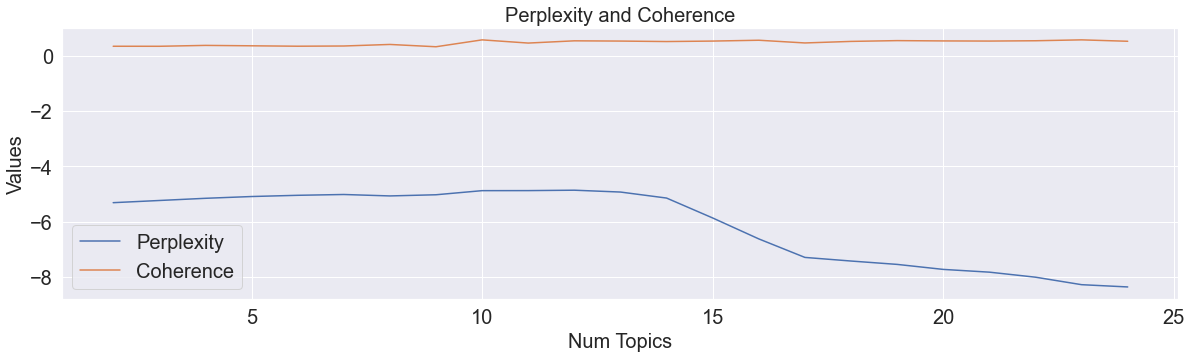

In [199]:
# plot results 
limit=25
start=2
x = range(start, limit)
plt.plot(x, perplexity_scores)
plt.plot(x, coherence_scores)
plt.figsize =(3,5)
plt.title("Perplexity and Coherence", fontsize = 20)
plt.xlabel("Num Topics", fontsize = 20)
plt.ylabel("Values", fontsize = 20)
plt.legend(['Perplexity', 'Coherence'],fontsize = 20, loc='best')
plt.tick_params(labelsize=20)
plt.show()

### The coherence score does not increase as the number of topics increase. Up to 15, the perplexity score does not decrease as the number of topics increase. This indicates that the ideal number of topics is likely to between 2 and 10. We avoid selecting any number over 10, since the model could overfit the data and create topics that have too much overlap. 

In [155]:
# Select the k = 5 as the optimal model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.069*"game" + 0.037*"player" + 0.033*"reward" + 0.028*"include" + '
  '0.026*"great" + 0.023*"buy" + 0.023*"server" + 0.023*"member" + '
  '0.023*"ship" + 0.023*"play"'),
 (1,
  '0.087*"game" + 0.058*"ad" + 0.033*"use" + 0.030*"get" + 0.028*"stop" + '
  '0.027*"much" + 0.026*"virus" + 0.026*"randomly" + 0.025*"also" + '
  '0.025*"match"'),
 (2,
  '0.042*"ad" + 0.040*"online" + 0.033*"watch" + 0.032*"happen" + '
  '0.030*"still" + 0.030*"never" + 0.028*"pvp" + 0.026*"game" + 0.024*"hit" + '
  '0.022*"time"'),
 (3,
  '0.114*"game" + 0.045*"make" + 0.029*"well" + 0.020*"problem" + 0.019*"lag" '
  '+ 0.018*"time" + 0.018*"horrible" + 0.018*"bad" + 0.018*"many" + '
  '0.016*"mode"'),
 (4,
  '0.088*"game" + 0.050*"fun" + 0.027*"second" + 0.026*"get" + 0.024*"play" + '
  '0.021*"screen" + 0.019*"suck" + 0.019*"degree" + 0.018*"tournament" + '
  '0.018*"pass"'),
 (5,
  '0.052*"game" + 0.041*"chest" + 0.037*"character" + 0.037*"always" + '
  '0.036*"get" + 0.031*"ad" + 0.027*"coin" + 0

In [172]:
# visualize the optimal model, namely the top 10 terms in each topic
def plot_topics (topic_num, axs):
    topic_dict = {}
    for i in range(len(optimal_model.show_topic(topic_num))):
        topic_dict[optimal_model.show_topic(topic_num)[i][0]] = optimal_model.show_topic(topic_num)[i][1]

    topic_terms = list(topic_dict.keys())
    beta = [float(topic_dict[k]) for k in topic_terms]
    plot = sns.barplot(x=beta, y = topic_terms, color = 'blue', ax = axs)
    plot.set_title("Topic " + str(topic_num +1), fontsize=25)
    plot.tick_params(labelsize=20)
    return plot

<AxesSubplot:title={'center':'Topic 5'}>

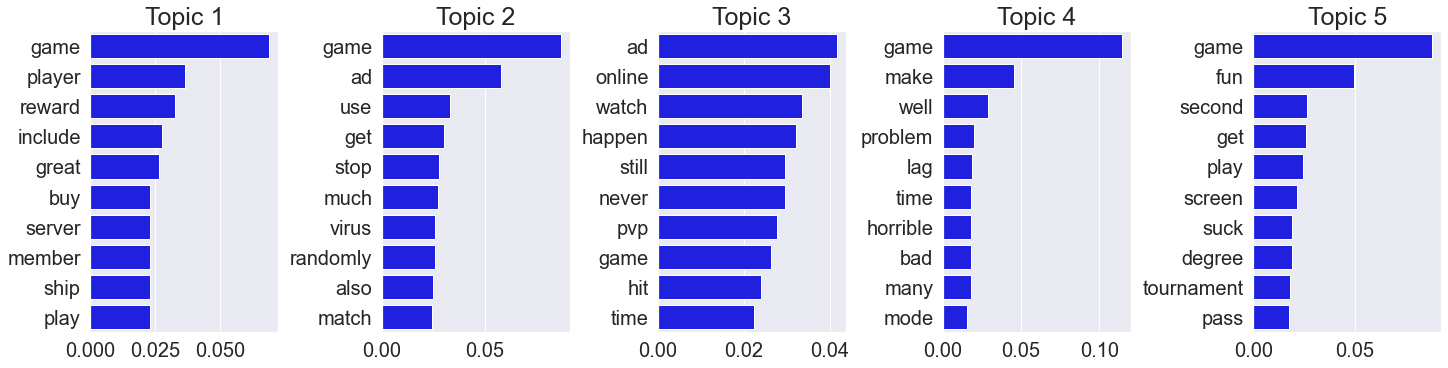

In [182]:
plt.rcParams["figure.figsize"] = (20,5)
fig, axs = plt.subplots(ncols= 5, constrained_layout=True)
plot_topics(0, axs[0])
plot_topics(1, axs[1])
plot_topics(2, axs[2])
plot_topics(3, axs[3])
plot_topics(4, axs[4])
#fig.tight_layout()

### Judging from these topics, its seems like Bowmasters' most prevalent problems are perhaps too many microtransactions in the game, too many ads, a persistent and horrible lag, and screen freezes or blackouts. Since topics 2 and 3 both contain 'ad', it might be in Bowmasters' interest to resolve this issue first. A similiar analysis can be conduct for Bowmasters' positive review to gauge areas of their App that they are excelling in.